# Imbalanced Classification: Probability Threshold Moving Techniques

### Main techniques used:
* Scaling
* Normalization
* Data Sampling - SMOTE+ENN
* **Probability Threshold Moving** (Optimizing for different metrics depending on business objective)

### Background:
* The Oil Spill Classification dataset is an example of an imbalanced classification problem where a class label is required, and both positive and negative classes are equally important. (Detecting and acting on a spill is an expensive response, so false positives are bad. However it is also equally expensive and bad to miss an oil spill event.)
* In this project, we will utilize various Probability Threshold Moving techniques to further improve classification metrics performance.

In [1]:
# Import necessary libraries

from matplotlib import pyplot
from collections import Counter

from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from imblearn.metrics import geometric_mean_score
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.dummy import DummyClassifier

from numpy import sqrt
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from numpy import arange

### Simple EDA of the data

(937, 50)
Class = 1.0, Count = 41, Percentage = 4.376%
Class = 0.0, Count = 896, Percentage = 95.624%


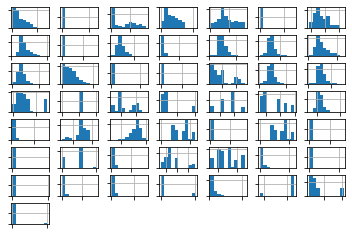

In [2]:
filename = 'oil-spill.csv'
dataframe = read_csv(filename, header=None)
print(dataframe.shape)

target = dataframe.values[:,-1]
counter = Counter(target)
for k, v in counter.items():
    per = v / len(target) * 100
    print(f"Class = {k}, Count = {v}, Percentage = {per:.3f}%")
    
ax = dataframe.hist()
for axis in ax.flatten():
    axis.set_title('')
    axis.set_xticklabels([])
    axis.set_yticklabels([])
pyplot.show()

**Note:** We can see that the target class distribution is quite imbalanced.

**Note:** We can also see that there are many different distributions, and we expect that scaling and using power transforms may be useful, before proceeding to modelling.

### Evaluate a Baseline Model for reference

In [3]:
# Define a few custom functions

def load_dataset(full_path):
    # load the dataset as a numpy array
    data = read_csv(full_path, header=None)
    # drop unused columns
    data.drop(22, axis=1, inplace=True)
    data.drop(0, axis=1, inplace=True)
    # retrieve numpy array
    data = data.values
    # split into input and output elements
    X, y = data[:, :-1], data[:, -1]
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X, y

# Evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(geometric_mean_score)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [4]:
# define the location of the dataset
full_path = 'oil-spill.csv'

# load the dataset
X, y = load_dataset(full_path)

# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))

# define the reference model
model = DummyClassifier(strategy='uniform')

# evaluate the model
scores = evaluate_model(X, y, model)

# summarize performance
# print('Mean G-Mean: %.3f (%.3f)' % (mean(scores), std(scores)))
print(f"Mean G-Mean: {mean(scores):.3f} ({std(scores):.3f}%)")

(937, 47) (937,) Counter({0: 896, 1: 41})
Mean G-Mean: 0.516 (0.102%)


**Note:** Remember that Sensitivity is a measure of accuracy for the positive class, and Specificity is a measure of accuracy for the negative class. 

**Note:** G-mean seeks a balance of the sensitivity score + the specificity score. Poor performance for either will be penalized.

**Note:** We can see that the baseline algorithm achieves a G-mean of about 0.50. This score provides us with a lower limit on model skill. Any model that achieves an average G-mean of above 0.50 has skill, whereas models that achieve a score below this value do not have skill on this dataset.

### Modelling

**Note:** In another project utilizing the same oil-spill dataset, we have shown that it is possible to attain good results by performing:
* Normalization, Power Transforms, SMOTEENN (data sampling technique) prior to training a classifier.
* After this, we will go on to evaluate various probability threshold moving techniques.

In [5]:
# Prepare the dataset here for modelling
full_path = 'oil-spill.csv'
X, y = load_dataset(full_path)

trainX, testX, trainy, testy = train_test_split(X, y, test_size = 0.3, random_state=88,
                                               stratify=y)


In [6]:
# Define the model here
sampling = SMOTEENN(enn = EditedNearestNeighbours(sampling_strategy='majority'))
model = LogisticRegression(solver='liblinear')
steps = [('t1', MinMaxScaler()), ('t2', PowerTransformer()), ('e', sampling), ('m', model)]
pipeline = Pipeline(steps=steps)
pipeline.fit(trainX, trainy)

Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()),
                ('e',
                 SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
                ('m', LogisticRegression(solver='liblinear'))])

In [7]:
# Predicted probabilities here
yhat = pipeline.predict_proba(testX)

# Predicted classes here (based on default threshold of 0.5 for classification)
y_pred_class = pipeline.predict(testX)

# Keep probabilities for the positive outcome only
yhat = yhat[:, 1]

In [8]:
print("Predicted Probabilities:")
print(yhat[:5])
print("Predicted Class Labels:")
print(y_pred_class[:5])

Predicted Probabilities:
[0.00033919 0.07791999 0.00380158 0.00025784 0.00174428]
Predicted Class Labels:
[0 0 0 0 0]


In [9]:
# We also define a custom function to apply a single selected threshold to interpret the predicted probabilities
# Threshold is applied to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

**Note:** A quick refresher on the layout of the confusion matrix. 

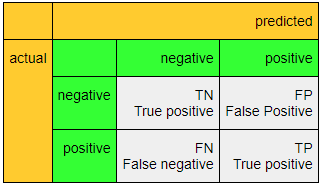

#### Optimal Threshold:
* **ROC Curves**
* Optimal balance between false positives and true positives rates
* **Largest G-mean value**

In [10]:
print(f"Default Threshold = 0.5, G-mean Score: {geometric_mean_score(testy, y_pred_class):.4f} \n")

print(f"Confusion Matrix based on Default Threshold: \n {confusion_matrix(testy, y_pred_class)} \n")

print(f"Classification Report based on Default Threshold: \n {classification_report(testy, y_pred_class)}")

Default Threshold = 0.5, G-mean Score: 0.7778 

Confusion Matrix based on Default Threshold: 
 [[245  25]
 [  4   8]] 

Classification Report based on Default Threshold: 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       270
           1       0.24      0.67      0.36        12

    accuracy                           0.90       282
   macro avg       0.61      0.79      0.65       282
weighted avg       0.95      0.90      0.92       282



In [11]:
# Calculate ROC Curves
fpr, tpr, thresholds = roc_curve(testy, yhat)

gmeans = sqrt(tpr * (1-fpr))

# Get best threshold
J = tpr - fpr
ix = argmax(J)
best_threshold = thresholds[ix]
print(f"Best Threshold = {best_threshold}, G-mean Score = {gmeans[ix]:.4f} \n")

print(f"Confusion Matrix based on selected Threshold: \n {confusion_matrix(testy, to_labels(yhat, 0.21772909351824177))} \n")

print(f"Classification Report based on selected Threshold: \n {classification_report(testy, to_labels(yhat, 0.21772909351824177))}")

Best Threshold = 0.28158514560300424, G-mean Score = 0.9309 

Confusion Matrix based on selected Threshold: 
 [[227  43]
 [  0  12]] 

Classification Report based on selected Threshold: 
               precision    recall  f1-score   support

           0       1.00      0.84      0.91       270
           1       0.22      1.00      0.36        12

    accuracy                           0.85       282
   macro avg       0.61      0.92      0.64       282
weighted avg       0.97      0.85      0.89       282



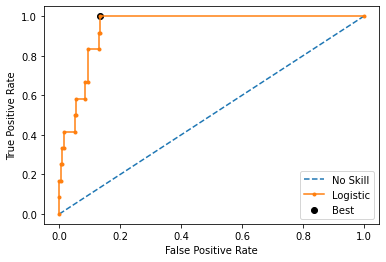

In [12]:
# Visualize the above results

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

**Note:**
* Using the default threshold of 0.5, the G-mean score was 0.7778.
* Using the Best Threshold found of 0.282, the G-mean score was 0.9309.
* In this case, when using G-mean/ G-score, the best threshold that optimizes for the best G-mean score results in a lower threshold for classifying a prediction as the positive class.
* As a result, there are more False Positives (25 FP in default 0.5 threshold vs 43 FP in optimized 0.282 threshold).
* The benefit is that all 5 previously misclassified positive class records (FN) were now detected (TP increased from 8 to 12).
* The business objective is important. Here, if operational capacity is not constrained, and it is a greater priority to detect the positive class records, then optimizing for G-mean may be good.

#### Optimal Threshold:
* **Precision-Recall Curves**
* Focuses on the performance of a classifier on the positive (minority class) only
* **Precision** = TP / (TP + FP)
* **Recall (aka Sensitivity)** = TP / (TP + FN)
* If interested in the optimal balance of precision and recall (i.e. Want to detect positives, but also constrained by volume of false positives.)
* **Largest F-measure value**

In [13]:
print(f"Default Threshold = 0.5, F1-Score/ F-measure: {f1_score(testy, y_pred_class):.4f} \n")

print(f"Confusion Matrix based on Default Threshold: \n {confusion_matrix(testy, y_pred_class)} \n")

print(f"Classification Report based on Default Threshold: \n {classification_report(testy, y_pred_class)}")

Default Threshold = 0.5, F1-Score/ F-measure: 0.3556 

Confusion Matrix based on Default Threshold: 
 [[245  25]
 [  4   8]] 

Classification Report based on Default Threshold: 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       270
           1       0.24      0.67      0.36        12

    accuracy                           0.90       282
   macro avg       0.61      0.79      0.65       282
weighted avg       0.95      0.90      0.92       282



In [14]:
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f-measure
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f-measure
ix = argmax(fscore)
print('Best Threshold=%f, F-measure=%.3f' % (thresholds[ix], fscore[ix]))

print(f"Confusion Matrix based on selected Threshold: \n {confusion_matrix(testy, to_labels(yhat, 0.977484))} \n")

print(f"Classification Report based on selected Threshold: \n {classification_report(testy, to_labels(yhat, 0.977484))}")

Best Threshold=0.982975, F-measure=0.476
Confusion Matrix based on selected Threshold: 
 [[266   4]
 [  7   5]] 

Classification Report based on selected Threshold: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       270
           1       0.56      0.42      0.48        12

    accuracy                           0.96       282
   macro avg       0.76      0.70      0.73       282
weighted avg       0.96      0.96      0.96       282



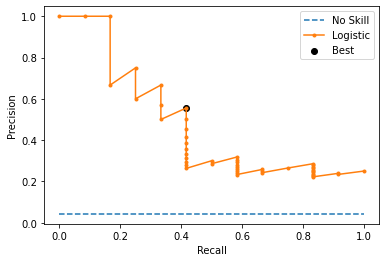

In [15]:
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


**Note:**
* In this case, when using F-measure/ F1-score, the best threshold that optimizes for the best f1-score results in a higher threshold for classifying a prediction as the positive class.
* As a result, there are much lower False Positives (25 FP in default 0.5 threshold vs 4 FP in optimized 0.983 threshold).
* The tradeoff is that 3 positive class records were missed (FN increased from 4 to 7).
* Again, it boils down to the business objective. Here, if operational capacity is constrained, and there is lesser bandwidth/ resources to investigate false positives, then optimizing for F-measure may be good.

#### Optimal Threshold:
* Finding the best threshold directly, based on F1 score.
* We will loop through small increments of the threshold to find the best threshold value.

In [16]:
# We define a range of threshold values to test
thresholds = arange(0, 1, 0.001)

In [17]:
# Evaluate each threshold using a list comprehension
scores = [f1_score(testy, to_labels(yhat, t)) for t in thresholds]

print(f"1st 5 thresholds: {list(round(i, 8) for i in scores[:5])}")
print(f"Last 5 thresholds: {list(round(i, 8) for i in scores[-5:])}")

# Get best threshold
ix = argmax(scores)

print(f"Best Threshold = {thresholds[ix]:.4f}, F-measure = {scores[ix]:.4f}")

1st 5 thresholds: [0.08163265, 0.11009174, 0.12698413, 0.13483146, 0.14545455]
Last 5 thresholds: [0.42105263, 0.42105263, 0.42105263, 0.44444444, 0.28571429]
Best Threshold = 0.9730, F-measure = 0.4762
